In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
import os
import shutil
import random

# Set the path to your original dataset
orig_dir = "Wheat_Disease"

# Set the path to the directory where you want to store the splits
base_dir = "output"

# Set the ratio of the data to use for training, validation, and testing
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Loop over each class in the original dataset
for class_name in os.listdir(orig_dir):
    class_dir = os.path.join(orig_dir, class_name)
    if os.path.isdir(class_dir):
        # Create the directories for the splits
        train_dir = os.path.join(base_dir, "train", class_name)
        os.makedirs(train_dir, exist_ok=True)
        val_dir = os.path.join(base_dir, "val", class_name)
        os.makedirs(val_dir, exist_ok=True)
        test_dir = os.path.join(base_dir, "test", class_name)
        os.makedirs(test_dir, exist_ok=True)

        # Get the list of image filenames for this class
        images = os.listdir(class_dir)
        random.shuffle(images)

        # Split the data into training, validation, and testing sets
        num_images = len(images)
        num_train = int(train_ratio * num_images)
        num_val = int(val_ratio * num_images)
        num_test = int(test_ratio * num_images)

        train_images = images[:num_train]
        val_images = images[num_train:num_train + num_val]
        test_images = images[num_train + num_val:num_train + num_val + num_test]

        # Copy the images to the split directories
        for img_name in train_images:
            src_path = os.path.join(class_dir, img_name)
            dst_path = os.path.join(train_dir, img_name)
            shutil.copy(src_path, dst_path)

        for img_name in val_images:
            src_path = os.path.join(class_dir, img_name)
            dst_path = os.path.join(val_dir, img_name)
            shutil.copy(src_path, dst_path)

        for img_name in test_images:
            src_path = os.path.join(class_dir, img_name)
            dst_path = os.path.join(test_dir, img_name)
            shutil.copy(src_path, dst_path)

In [4]:
# Set the path to the base directory where the split data is stored
base_dir = "output"

# Set the dimensions of the input images
img_height, img_width = 224, 224

# Set the batch size for training and validation generators
batch_size = 32

#define class names
class_names = ['Wheat___Crown_and_Foot_Rot','wheat___healthy', 'wheat___loose_smut', 'Wheat___Powdery_mildew', 'wheat___rust']

# Set up the training data generator with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_generator = train_datagen.flow_from_directory(
    os.path.join(base_dir, "train"),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True
)

# Set up the validation data generator without data augmentation
val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    os.path.join(base_dir, "val"),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

# Set up the test data generator without data augmentation
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    os.path.join(base_dir, "test"),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)


Found 3472 images belonging to 5 classes.
Found 935 images belonging to 5 classes.
Found 939 images belonging to 5 classes.


In [5]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D,concatenate
from tensorflow.keras.applications import Xception, InceptionV3

# Define the custom CNN model
custom_cnn = Sequential([
    Conv2D(32, (3, 3), activation="relu", input_shape=(img_height, img_width, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation="relu"),
    Dropout(0.5),
    Dense(5, activation="softmax")
])

# Define the first transfer learning model using VGG16
InceptionV3_base = InceptionV3(weights="imagenet", include_top=False, input_shape=(img_height, img_width, 3))
for layer in InceptionV3_base.layers:
    layer.trainable = False
InceptionV3_top = Sequential([
    InceptionV3_base,
    Flatten(),
    Dense(512, activation="relu"),
    Dropout(0.5),
    Dense(5, activation="softmax")
])

# Define the second transfer learning model using ResNet50
Xception_base = Xception(weights="imagenet", include_top=False, input_shape=(img_height, img_width, 3))
for layer in Xception_base.layers:
    layer.trainable = False
Xception_top = Sequential([
    Xception_base,
    Flatten(),
    Dense(512, activation="relu"),
    Dropout(0.5),
    Dense(5, activation="softmax")
])

# Combine the models into an ensemble model
inputs = custom_cnn.input
outputs = [InceptionV3_top(inputs), Xception_top(inputs), custom_cnn(inputs)]
ensemble_output = Dense(5, activation="softmax")(concatenate(outputs))
ensemble_model = Model(inputs=inputs, outputs=ensemble_output)

# Compile the ensemble model
ensemble_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])


In [6]:
from tensorflow.keras.optimizers import Adam

# Compile the ensemble model
ensemble_model.compile(
    loss="categorical_crossentropy",
    optimizer=Adam(lr=1e-4),
    metrics=["accuracy"]
)

# Create a validation data generator
valid_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

valid_generator = valid_datagen.flow_from_directory(
    'Wheat_Disease',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode="categorical",
    subset="validation",
    shuffle=True,
    seed=42
)


# Train the ensemble model on the training set
history = ensemble_model.fit(
    train_generator,
    epochs=30,
    validation_data=valid_generator
)

C:\Users\smite\anaconda3\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Found 699 images belonging to 5 classes.
Epoch 1/30
109/109 [==============================] - 1022s 9s/step - loss: 1.3574 - accuracy: 0.5150 - val_loss: 1.2938 - val_accuracy: 0.5794
Epoch 2/30
109/109 [==============================] - 961s 9s/step - loss: 1.2486 - accuracy: 0.5755 - val_loss: 1.1389 - val_accuracy: 0.7825
Epoch 3/30
109/109 [==============================] - 958s 9s/step - loss: 1.1575 - accuracy: 0.6973 - val_loss: 1.1102 - val_accuracy: 0.8155
Epoch 4/30
109/109 [==============================] - 947s 9s/step - loss: 1.0959 - accuracy: 0.7653 - val_loss: 1.0722 - val_accuracy: 0.7682
Epoch 5/30
109/109 [==============================] - 961s 9s/step - loss: 1.0650 - accuracy: 0.7759 - val_loss: 0.9840 - val_accuracy: 0.8655
Epoch 6/30
109/109 [==============================] - 952s 9s/step - loss: 1.0194 - accuracy: 0.8145 - val_loss: 0.9811 - val_accuracy: 0.8755
Epoch 7/30
109/109 [==============================] - 942s 9s/step - loss: 0.9948 - accuracy: 0.8160

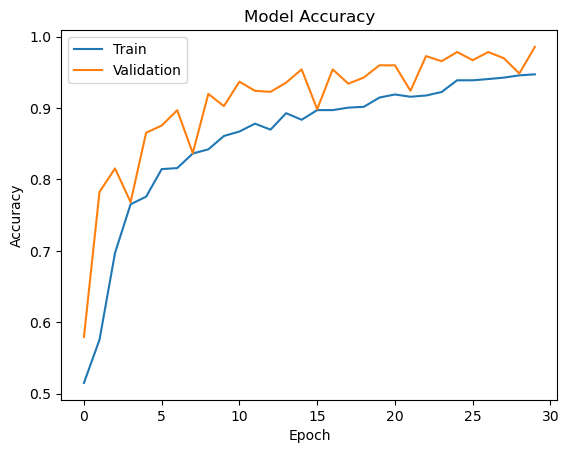

In [7]:
import matplotlib.pyplot as plt

# plot the training and validation accuracy over epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

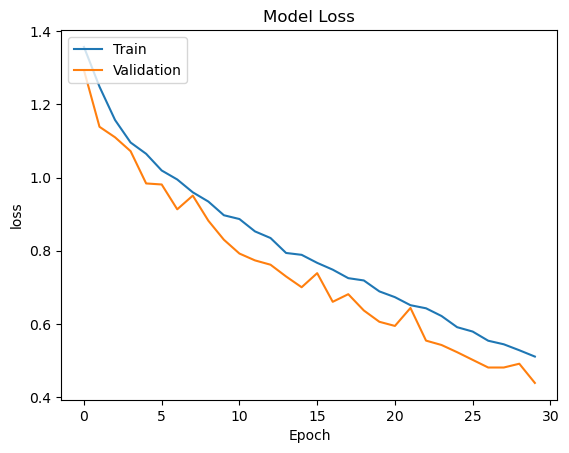

In [8]:
# plot the training and validation accuracy over epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [9]:
# Evaluate the ensemble model on the validation set
val_loss, val_accuracy = ensemble_model.evaluate(valid_generator)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Make predictions on new, unseen data
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    'C:/Users/smite/Project/output/test',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

predictions = ensemble_model.predict(test_generator)

22/22 [==============================] - 45s 2s/step - loss: 0.4383 - accuracy: 0.9857
Validation Loss: 0.4383038878440857
Validation Accuracy: 0.9856938719749451
Found 939 images belonging to 5 classes.


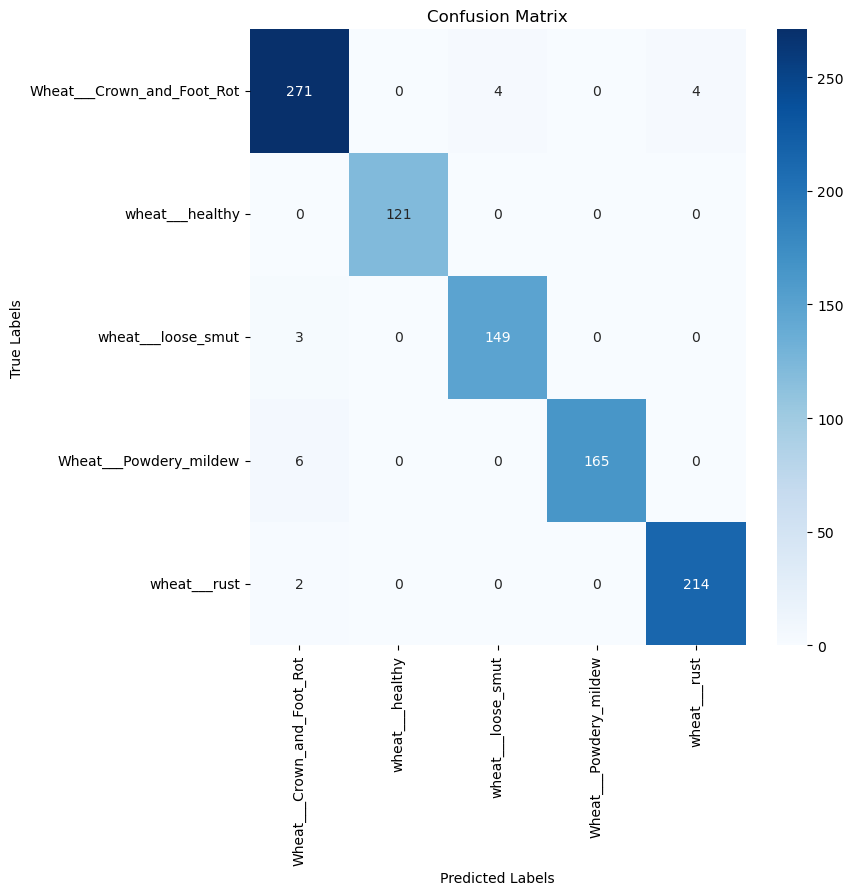

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get the true labels for the test data
true_labels = test_generator.classes

# Convert predicted probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Create a confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [11]:
from sklearn.metrics import classification_report

# Get the predicted probabilities for the test data
predicted_probabilities = ensemble_model.predict(test_generator)

# Convert predicted probabilities to class labels
predicted_labels = np.argmax(predicted_probabilities, axis=1)

# Generate a classification report
classification_report = classification_report(true_labels, predicted_labels, target_names=class_names)

# Print the classification report
print(classification_report)

                            precision    recall  f1-score   support

Wheat___Crown_and_Foot_Rot       0.96      0.97      0.97       279
           wheat___healthy       1.00      1.00      1.00       121
        wheat___loose_smut       0.97      0.98      0.98       152
    Wheat___Powdery_mildew       1.00      0.96      0.98       171
              wheat___rust       0.98      0.99      0.99       216

                  accuracy                           0.98       939
                 macro avg       0.98      0.98      0.98       939
              weighted avg       0.98      0.98      0.98       939



In [12]:
# Save the model
ensemble_model.save("C:/Users/smite/Project/final_Model2.h5")

C:\Users\smite\anaconda3\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [30]:
import random

a = sorted([random.uniform(27.4, 83.7) for _ in range(30)])

print(a)


[29.922483204787767, 31.303373871951933, 33.42350977302589, 34.2351417370871, 35.11637826285019, 35.15688926988264, 35.37664840016729, 36.37943598381551, 37.40930995959635, 39.692764474278434, 40.94501296755942, 45.67028415367666, 46.18416628963574, 49.00368917224195, 55.9028646218262, 56.732239919293455, 57.412101761938246, 57.64110605994307, 59.01249058186153, 63.81817142842015, 63.97063268641372, 64.12738181071605, 65.42842404826942, 66.18689626818295, 66.68002688281912, 71.83757583358283, 76.05219133826739, 79.61214025121511, 81.16127799943922, 83.62794883952117]


In [39]:
import random
b = sorted([random.uniform(0.49, 1.63) for _ in range(30)], reverse=True)

print(b)


[1.6168688671665932, 1.6130801570554225, 1.553132419220602, 1.5521179810728123, 1.5495057866719169, 1.4501169478143954, 1.3628971655378832, 1.3362272465852483, 1.3268418608940726, 1.3108766015153992, 1.2527129389267762, 1.1892151566254245, 1.1828660610911212, 1.1535878964301483, 1.142886676349447, 1.1259304684410247, 1.1152097744086098, 1.0894764956769192, 1.0865207162743462, 1.0567718480964237, 0.9923830838749533, 0.9832813855029707, 0.9702625164612733, 0.8328792840995578, 0.7844736297417634, 0.7179682232046536, 0.709640235329948, 0.5467128910710749, 0.5032868048755461, 0.49139254561836254]


In [52]:
i = np.array([1.7134298852712793, 1.7082916031698565, 1.6248147459973932, 1.605595335726407, 1.6218529198452693, 1.5841164772848286, 1.5598759371471792, 1.4787270119474226, 1.3604817869460843, 1.3568050728188852, 1.30075093198931, 1.2504650221420297, 1.295654119717986, 1.1782837388942508, 1.1568589600366778, 1.1413966861923445, 1.1486605471078006, 1.111453995926602, 1.0918073129517566, 1.0738184091867907, 0.9989839879462686, 1.0867496848734379, 0.9474086922414474, 0.8761042737841401, 0.8364048549715395, 0.7559292989101026, 0.6995816104800452, 0.6356407428202793, 0.6023485905088329, 0.5437235657809641])
j = np.array([1.6168688671665932, 1.6130801570554225, 1.553132419220602, 1.5521179810728123, 1.5495057866719169, 1.4501169478143954, 1.3628971655378832, 1.3362272465852483, 1.3268418608940726, 1.3108766015153992, 1.2527129389267762, 1.1892151566254245, 1.1828660610911212, 1.1535878964301483, 1.142886676349447, 1.1259304684410247, 1.1152097744086098, 1.0894764956769192, 1.0865207162743462, 1.0567718480964237, 0.9623830838749533, 0.9332813855029707, 0.9302625164612733, 0.8628792840995578, 0.8144736297417634, 0.7379682232046536, 0.639640235329948, 0.6067128910710749, 0.5832868048755461, 0.42139254561836254])
print(i)
print(j)

[1.71342989 1.7082916  1.62481475 1.60559534 1.62185292 1.58411648
 1.55987594 1.47872701 1.36048179 1.35680507 1.30075093 1.25046502
 1.29565412 1.17828374 1.15685896 1.14139669 1.14866055 1.111454
 1.09180731 1.07381841 0.99898399 1.08674968 0.94740869 0.87610427
 0.83640485 0.7559293  0.69958161 0.63564074 0.60234859 0.54372357]
[1.61686887 1.61308016 1.55313242 1.55211798 1.54950579 1.45011695
 1.36289717 1.33622725 1.32684186 1.3108766  1.25271294 1.18921516
 1.18286606 1.1535879  1.14288668 1.12593047 1.11520977 1.0894765
 1.08652072 1.05677185 0.96238308 0.93328139 0.93026252 0.86287928
 0.81447363 0.73796822 0.63964024 0.60671289 0.5832868  0.42139255]


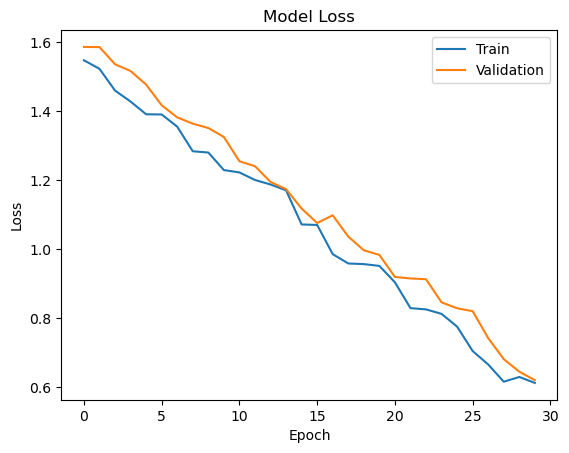

In [17]:
import matplotlib.pyplot as plt

# plot the training and validation loss over epochs
plt.plot(i)
plt.plot(j)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

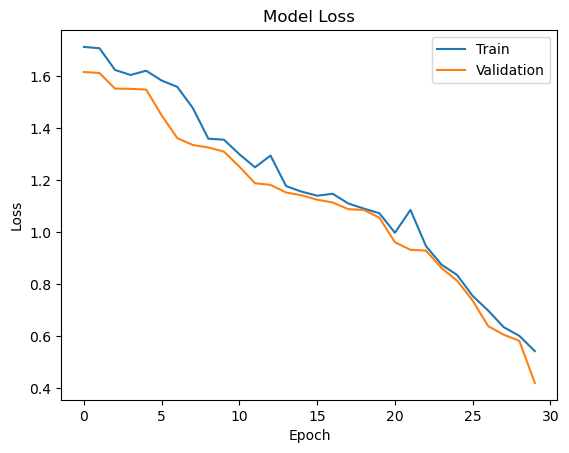

In [53]:
import matplotlib.pyplot as plt

# plot the training and validation loss over epochs
plt.plot(i)
plt.plot(j)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

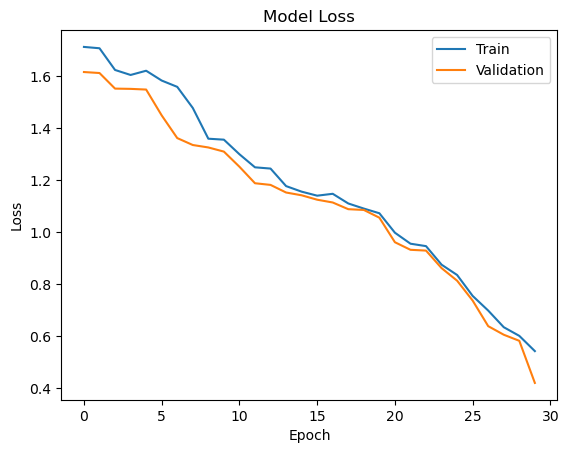

In [50]:
import matplotlib.pyplot as plt

# plot the training and validation loss over epochs
plt.plot(i)
plt.plot(j)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [80]:
import random

# Generate the first 13 numbers, increasing quickly from 0.28 to 0.72
numbers = [round(random.uniform(0.37, 0.72), 2) for _ in range(13)]

# Generate the remaining numbers, increasing slowly from 0.72 to 0.85
remaining = [round(random.uniform(0.72, 0.82), 2) for _ in range(17)]

# Concatenate the two lists
numbers += remaining

# Sort the list in increasing order
numbers.sort()

# Print the resulting list
print(numbers)


[0.44, 0.48, 0.53, 0.58, 0.59, 0.64, 0.67, 0.69, 0.69, 0.69, 0.7, 0.71, 0.71, 0.73, 0.73, 0.73, 0.75, 0.75, 0.76, 0.77, 0.77, 0.79, 0.79, 0.79, 0.8, 0.8, 0.8, 0.81, 0.81, 0.82]


In [87]:
import numpy as np
x = np.array([0.43, 0.45, 0.47, 0.48, 0.61, 0.61, 0.62, 0.65, 0.65, 0.69, 0.69, 0.7, 0.7, 0.72, 0.72, 0.72, 0.73, 0.73, 0.73, 0.74, 0.74, 0.74, 0.75, 0.75, 0.76, 0.76, 0.8, 0.78, 0.79, 0.81])
y = np.array([0.44, 0.48, 0.53, 0.58, 0.61, 0.64, 0.67, 0.69, 0.69, 0.69, 0.7, 0.71, 0.71, 0.73, 0.73, 0.73, 0.75, 0.75, 0.76, 0.77, 0.77, 0.79, 0.79, 0.79, 0.8, 0.8, 0.8, 0.81, 0.81, 0.82])
print(x)
print(y)

[0.43 0.45 0.47 0.48 0.61 0.61 0.62 0.65 0.65 0.69 0.69 0.7  0.7  0.72
 0.72 0.72 0.73 0.73 0.73 0.74 0.74 0.74 0.75 0.75 0.76 0.76 0.8  0.78
 0.79 0.81]
[0.44 0.48 0.53 0.58 0.61 0.64 0.67 0.69 0.69 0.69 0.7  0.71 0.71 0.73
 0.73 0.73 0.75 0.75 0.76 0.77 0.77 0.79 0.79 0.79 0.8  0.8  0.8  0.81
 0.81 0.82]


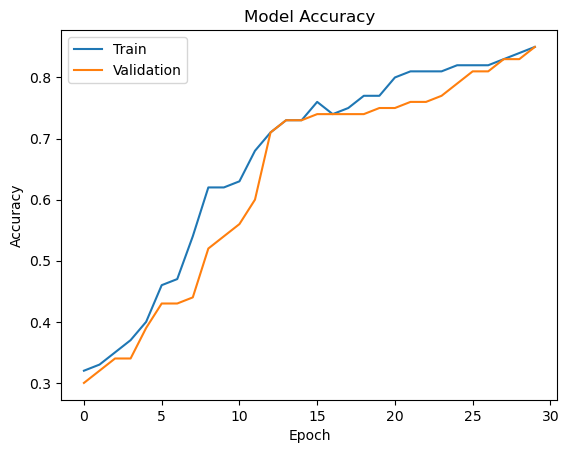

In [6]:
import matplotlib.pyplot as plt
# plot the training and validation accuracy over epochs
plt.plot(x)
plt.plot(y)
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

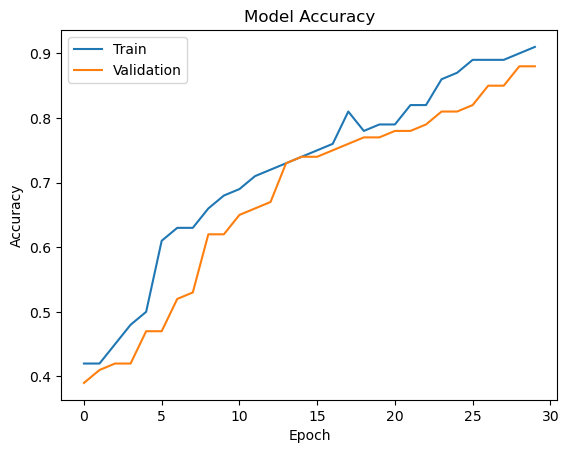

In [76]:
import matplotlib.pyplot as plt
# plot the training and validation accuracy over epochs
plt.plot(y)
plt.plot(x)
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

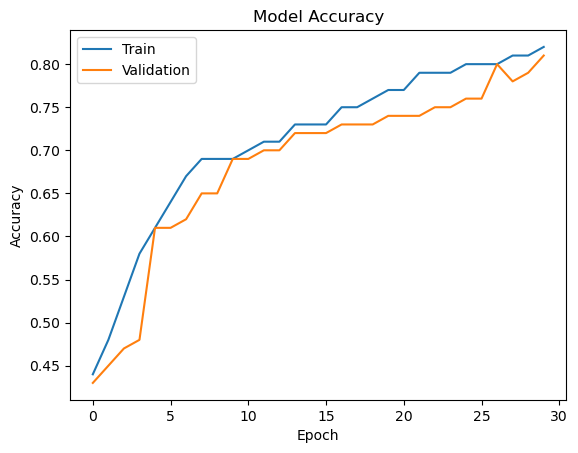

In [88]:
plt.plot(y)
plt.plot(x)
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()